In [1]:
import logging
import multiprocessing
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed
from typing import Optional, List, Collection

from causalpy import Assignment
from causalpy.neural_networks import FCNet
from causalpy.causal_prediction.interventional import (
    AgnosticPredictor,
    MultiAgnosticPredictor,
)
from examples.study_cases import study_scm, generate_data_from_scm
import numpy as np
import torch
from plotly import graph_objs as go
from time import gmtime, strftime
import os

from tqdm import tqdm
import matplotlib.pyplot as plt


/home/michael/anaconda3/envs/causalpy/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [96]:
import itertools
from typing import Optional, Callable, Type, Tuple, List, Union

import torch
from causalpy.neural_networks.utils import get_jacobian
from abc import ABC, abstractmethod
import numpy as np


class CouplingBase(torch.nn.Module, ABC):
    def __init__(
        self,
        dim: int,
        dim_condition: int,
        nr_layers: int = 16,
        conditional_net: Optional[torch.nn.Module] = None,
        seed: int = None,
        device: torch.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        ),
    ):
        super().__init__()
        self.device = device
        self.log_jacobian_cache = 0
        self.dim = dim
        self.dim_condition = dim_condition
        self.nr_layers = nr_layers
        self.nr_inverse_iters = 10

        # dummy buffers which become filled with parameters for the non conditional case.
        # otherwise these will hold the values given by the conditional net.
        self.mat_like_params = [
            torch.empty(1, self.dim, self.nr_layers, device=device).to(device),
            torch.empty(1, self.dim, self.nr_layers, device=device).to(device),
            torch.empty(1, self.dim, self.nr_layers, device=device).to(device),
        ]
        self.vec_like_params = [
            torch.empty(1, self.dim, device=device).to(device),  # bias2
            torch.empty(1, self.dim, device=device).to(device),  # eps
            torch.empty(1, self.dim, device=device).to(device),  # alpha
        ]

        self.is_conditional = dim_condition > 0
        if self.is_conditional:
            self.matrix_shape = (self.dim, self.nr_layers)
            self.bias_shape = (self.dim,)

            if conditional_net is None:
                self.conditional_net: torch.nn.Module = torch.nn.Sequential(
                    torch.nn.Linear(dim_condition, 50),
                    torch.nn.ReLU(),
                    torch.nn.Linear(50, 3 * dim * (nr_layers + 1)),
                )
            else:
                # conditional net needs to fulfill:
                # ( dimension in = dim_condition, dimension out = 3 * dim * (nr_layers + 1) )
                with torch.no_grad():
                    out = conditional_net(torch.ones(1, dim_condition))
                    assert out.size() == (1, 3 * dim * (nr_layers + 1),), (
                        f"Size mismatch: Conditional network needs to output size "
                        f"[batch_size, 3*dim*(nr_layers+1) = {3 * dim * (nr_layers + 1)}]. "
                        f"Provided was [out] = [{tuple([*out.size()])}]."
                    )
                self.conditional_net: torch.nn.Module = conditional_net
        else:
            # only in the case of no conditional neural network are these trainable parameters.
            # Otherwise their data will be provided by the condition generating network.
            self.reset_parameters(seed)
            self.mat_like_params = torch.nn.ParameterList(
                [
                    torch.nn.Parameter(tensor, requires_grad=True)
                    for tensor in self.mat_like_params
                ]
            ).to(device)
            self.vec_like_params = torch.nn.ParameterList(
                [
                    torch.nn.Parameter(tensor, requires_grad=True)
                    for tensor in self.vec_like_params
                ]
            ).to(device)

    def reset_parameters(self, seed=None):
        if self.is_conditional:
            with torch.no_grad():
                if isinstance(self.conditional_net, torch.nn.Sequential):
                    for layer in self.conditional_net:
                        if list(layer.parameters()):
                            # true if the layer has any parameters (e.g. false for a ReLu)
                            layer.reset_parameters()
                else:
                    # in case the net is external we expect it to have a reset parameters method.
                    self.conditional_net.reset_parameters()
        else:
            self._reset_conditional_parameters(seed)

    def _reset_conditional_parameters(self, seed=None):
        if seed is not None:
            torch.manual_seed(seed)
        with torch.no_grad():
            for mat in self.mat_like_params:
                mat.normal_(mean=0, std=1)
            # vec-like params
            self.bias2.normal_(mean=0, std=1)
            self.eps.fill_(value=1)
            self.alpha.fill_(value=0)

    @property
    def mat1(self):
        return self.mat_like_params[0]

    @property
    def bias1(self):
        return self.mat_like_params[1]

    @property
    def mat2(self):
        return self.mat_like_params[2]

    @property
    def bias2(self):
        return self.vec_like_params[0]

    @property
    def eps(self):
        return self.vec_like_params[1]

    @property
    def alpha(self):
        return self.vec_like_params[2]

    def forward(
        self,
        x: torch.Tensor,
        condition: Optional[torch.Tensor] = None,
        reverse: bool = False,
    ):
        if self.is_conditional:
            self.set_conditional_params(condition)

        if not reverse:
            self.log_jacobian_cache = torch.log(self.transform_deriv(x))
            return self.transform(x)
        else:
            z = self.transform_inverse(x, nr_iters=self.nr_inverse_iters)
            self.log_jacobian_cache = -torch.log(self.transform_deriv(z))
            return z

    @abstractmethod
    def transform(self, x: torch.Tensor):
        raise NotImplementedError

    @abstractmethod
    def transform_deriv(self, x: torch.Tensor):
        raise NotImplementedError

    def transform_inverse(self, y: torch.Tensor, nr_iters=10):
        """
        Newton method for iterative approximation of the inverse g of the transformation f at point y: g(y).
        """
        yn = y  # * torch.exp(-self.alpha) - self.bias2
        with torch.no_grad():
            for i in range(nr_iters - 1):
                yn = yn - (self.transform(yn) - y) / self.transform_deriv(yn)
        return yn - (self.transform(yn) - y) / self.transform_deriv(yn)

    def set_conditional_params(self, condition: torch.Tensor):
        """
        In the case of a conditional INN set the parameters of the bijective map for the condition.

        Notes
        -----
        If this method was called although the INN is unconditional, uncaught errors will be raised.
        """
        assert (
            self.is_conditional
        ), "Conditional parameters can only be set when the INN is conditional. They are learned otherwise."
        size = condition.size(0)
        new_params = self.conditional_net(condition)

        begin = 0

        def reshape(param_list, new_shape):
            nonlocal begin
            for i, param in enumerate(param_list):
                # [1:] to ignore batch size (dim 0) of last run
                end = begin + np.prod(param.size()[1:])
                param_list[i] = torch.reshape(new_params[:, begin:end], new_shape)
                begin = end

        reshape(self.mat_like_params, (size,) + self.matrix_shape)
        reshape(self.vec_like_params, (size,) + self.bias_shape)

    def jacobian(self, x: Optional[torch.Tensor] = None, rev: bool = False):
        if x is None:
            return self.log_jacobian_cache
        else:
            return get_jacobian(self, x, dim_in=1, dim_out=1, device=self.device)


class CouplingMonotone(CouplingBase):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.elu = torch.nn.ELU()

    def activation_func(self, x):
        return self.elu(x)

    def activation_deriv(self, x):
        return 1 + self.activation_func(-torch.relu(-x))

    def transform(self, x):
        internal_sum = torch.sum(
            self.mat2
            * self.activation_func(
                x.unsqueeze(2).expand(-1, -1, self.nr_layers) * self.mat1 + self.bias1
            ),
            dim=2,
        )
        divisor = torch.sum(torch.relu(-self.mat1 * self.mat2), dim=2) + 1
        return (
            self.alpha.exp()
            * (x + 0.8 * torch.sigmoid(self.eps) * internal_sum / divisor)
            + self.bias2
        )

    def transform_deriv(self, x):
        internal_sum = torch.sum(
            self.activation_deriv(
                x.unsqueeze(2).expand(-1, -1, self.nr_layers) * self.mat1 + self.bias1
            )
            * self.mat1
            * self.mat2,
            dim=2,
        )
        divisor = torch.sum(torch.relu(-self.mat1 * self.mat2), dim=2) + 1
        return self.alpha.exp() * (
            1 + 0.8 * torch.sigmoid(self.eps) * internal_sum / divisor
        )


class CouplingGeneral(CouplingBase):
    @staticmethod
    def activation_func(x):
        # return torch.tanh(x)
        return torch.exp(-(x ** 2)) * 1.16

    @staticmethod
    def activation_deriv(x):
        # return 1 - self.activation_func(x) ** 2
        return -2 * x * CouplingGeneral.activation_func(x)

    def transform(self, x: torch.Tensor):
        internal_sum = torch.sum(
            self.activation_func(
                x.unsqueeze(2).expand(-1, -1, self.nr_layers) * self.mat1 + self.bias1
            )
            * self.mat2,
            dim=2,
        )
        divisor = torch.sum(torch.abs(self.mat1 * self.mat2), dim=2) + 1
        return (
            torch.exp(self.alpha)
            * (x + 0.8 * torch.sigmoid(self.eps) * internal_sum / divisor)
            + self.bias2
        )

    def transform_deriv(self, x: torch.Tensor):
        internal_sum = torch.sum(
            self.activation_deriv(
                x.unsqueeze(2).expand(-1, -1, self.nr_layers) * self.mat1 + self.bias1
            )
            * self.mat1
            * self.mat2,
            dim=2,
        )
        divisor = torch.sum(torch.abs(self.mat1 * self.mat2), dim=2) + 1
        return torch.exp(self.alpha) * (
            1 + 0.8 * torch.sigmoid(self.eps) * internal_sum / divisor
        )


class CINN(torch.nn.Module):
    def __init__(
        self,
        dim: int,
        dim_condition,
        nr_blocks: int = 3,
        nr_layers: int = 16,
        normalize_forward: bool = True,
        conditional_net: Optional[torch.nn.Module] = None,
        seed = None,
        device: Union[str, torch.device] = "cuda"
        if torch.cuda.is_available()
        else "cpu",
    ):
        super().__init__()
        self.nr_blocks = nr_blocks

        # whether we pass through the network in the forward or backward direction for normalizing.
        self.normalize_forward = normalize_forward

        if conditional_net is not None:
            conditional_net = conditional_net.to(device)

        self.blocks = torch.nn.ModuleList([])
        for i in range(nr_blocks):
            self.blocks.append(
                CouplingGeneral(
                    dim=dim,
                    nr_layers=nr_layers,
                    dim_condition=dim_condition,
                    conditional_net=conditional_net,
                    seed=seed,
                    device=device,
                )
            )
            self.blocks.append(
                CouplingMonotone(
                    dim=dim,
                    nr_layers=nr_layers,
                    dim_condition=dim_condition,
                    conditional_net=conditional_net,
                    seed=seed,
                    device=device,
                )
            )
        self.log_jacobian_cache = torch.zeros(dim)

    def forward(
        self,
        x: torch.Tensor,
        condition: Optional[torch.Tensor] = None,
        reverse: bool = False,
    ):
        self.log_jacobian_cache = 0.0

        block_iter = self.blocks[::-1] if reverse else self.blocks
        for block in block_iter:
            x = block(x=x, condition=condition, reverse=reverse)
            self.log_jacobian_cache += block.jacobian()

        return x

    def normalizing_flow(
        self, target: torch.Tensor, condition: Optional[torch.Tensor] = None,
    ):
        """
        Transport the incoming target samples `x` under condition `condition` to the gauss distribution.
        This is referred to as the normalizing flow direction.

        Notes
        -----
        Whether normalizing is the forward pass or the inverse pass through the flow architecture is defined
        in the parameter `normalize_forward`.
        """
        return self(target, condition=condition, reverse=not self.normalize_forward)

    def generating_flow(
        self, normals: torch.Tensor, condition: Optional[torch.Tensor] = None,
    ):
        """
        Transport the incoming gaussian samples `x` under condition `condition` to the target distribution.
        This is referred to as the generating flow direction.

        Notes
        -----
        Whether normalizing is the forward pass or the inverse pass through the flow architecture is defined
        in the parameter `normalize_forward`.
        """
        return self(normals, condition=condition, reverse=self.normalize_forward)

    def jacobian(self, x: Optional[torch.Tensor], rev: bool = False):
        if x is None:
            return self.log_jacobian_cache
        else:
            return get_jacobian(
                self, x, dim_in=1, dim_out=1, device=self.device, rev=rev
            )

    def reset_parameters(self):
        for block in self.blocks:
            block.reset_parameters()


In [97]:
class CINNFC(torch.nn.Module, Assignment):
    def __init__(
        self,
        dim_in: int,
        nr_layers: int = 0,
        nr_blocks: int = 1,
        strength: float = 0.0,
        seed = None,
        device=None,
        **kwargs,
    ):
        super().__init__()
        Assignment.__init__(self)
        self.nr_layers = nr_layers
        self.dim_in = dim_in - 1
        self.strength = strength
        self.device = device
        # -1 bc additive noise
        self.cinn = CINN(
            dim=dim_in - 1,
            dim_condition=0,
            nr_layers=nr_layers,
            nr_blocks=nr_blocks,
            seed=seed,
            device="cuda",
        )

    def forward(self, *args, **kwargs):
        with torch.no_grad():
            noise = (
                torch.from_numpy(np.array(list(args), dtype=np.float32).T)
                .to(self.device)
                .reshape(-1, 1)
            )
            variables = (
                torch.from_numpy(np.array(list(kwargs.values()), dtype=np.float32).T)
                .squeeze(0)
                .to(self.device)
                .reshape(noise.shape[0], -1)
            )

            x = variables
            #             print(noise.shape)
            if self.dim_in > 0:
                base = torch.cat((noise, variables), dim=1).to(self.device)
            else:
                base = noise

            #             print("Baseshape", base.shape)

            if self.dim_in == 0:
                nonlin_part = noise
            else:
                ev = self.cinn(x)[:, 0].reshape(-1, 1)
                #                 print("EV", ev.shape)
                #                 print("NOise", noise.shape)
                nonlin_part = ev + noise

            #             print("nonlin", nonlin_part.shape)

            base_sum = torch.sum(base, dim=1).view(-1, 1)

            x = nonlin_part * self.strength + (1 - self.strength) * base_sum

            return x.cpu().numpy().reshape(-1)

    def __len__(self):
        raise 2

    def function_str(self, variable_names: Optional[Collection[str]] = None):
        return f"CINN({', '.join(variable_names)})"



In [137]:
model = CINNFC
def fc_net(nr_layers: int, nr_hidden, strength: float, nr_blocks=1, seed = None, device="cuda"):
    if seed is not None:
        network_params = [{
            "nr_layers": nr_layers,
            "nr_blocks": nr_blocks,
            "nr_hidden": nr_hidden,
            "strength": strength,
            "seed": seed,
            "device": device,
        } for seed in range(seed+1, seed+1 + 10)]
    else:
        network_params = [{
            "nr_layers": nr_layers,
            "nr_blocks": nr_blocks,
            "nr_hidden": nr_hidden,
            "strength": strength,
            "seed": seed,
            "device": device,
        } for _ in range(10)]
    nets = {
        "X_0": CINNFC(dim_in=1, **(network_params)[0]).to(device),
        "X_1": CINNFC(dim_in=2, **(network_params)[1]).to(device),
        "X_2": CINNFC(dim_in=2, **(network_params)[2]).to(device),
        "X_3": CINNFC(dim_in=1, **(network_params)[3]).to(device),
        "X_4": CINNFC(dim_in=3, **(network_params)[9]).to(device),
        "X_5": CINNFC(dim_in=1, **(network_params)[5]).to(device),
        "X_6": CINNFC(dim_in=3, **(network_params)[6]).to(device),
        "X_7": CINNFC(dim_in=2, **(network_params)[7]).to(device),
        "X_8": CINNFC(dim_in=1, **(network_params)[8]).to(device),
        "Y": CINNFC(dim_in=4, **(network_params)[4]).to(device),
    }
    return nets


In [142]:
def run_scenario(
    Predictor, params, sample_size, nr_runs, epochs, scenario, step, **kwargs
):
    seed = 0
    np.random.seed(seed)
    # print(coeffs)
    scm = study_scm(seed=seed)
    standard_sample = scm.sample(sample_size)
#     print(scm)

    nets = fc_net(**params)
    scm.intervention(
        {
            "X_0": (None, nets["X_0"], None),
            "X_1": (None, nets["X_1"], None),
            "X_2": (None, nets["X_2"], None),
            "X_3": (None, nets["X_3"], None),
            "X_4": (None, nets["X_4"], None),
            "X_5": (None, nets["X_5"], None),
            "X_6": (None, nets["X_6"], None),
            "X_7": (None, nets["X_7"], None),
            "Y": (None, nets["Y"], None),
        }
    )
    scm.clear_intervention_backup()  # make the current intervention the standard
#     print(scm)
    # scm.plot(alpha=1)
    # plt.show()
    (
        data,
        environments,
        scm,
        possible_parents,
        target_parents,
    ) = generate_data_from_scm(scm, target_var="Y", sample_size=sample_size, seed=seed)
    
#     fig = plt.figure()
#     plt.hist(
#         standard_sample["Y"],
#         color="green",
#         label="Standard Linear",
#         density=True,
#         bins=200,
#         alpha=0.5,
#     )
#     plt.hist(
#         data["Y"],
#         color="red",
#         label=f"FC (L: {params['nr_layers']}, B: {params['nr_blocks']}, S: {params['strength']}) applied",
#         density=True,
#         bins=200,
#         alpha=0.5,
#     )

#     plt.legend()
    print(np.isnan(data).sum())
    return standard_sample, data





In [143]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
PredictorClass = AgnosticPredictor
steps = 10
sample_size = 2048
nr_runs = 20
epochs = 1000
results = []
scenarios = ["parents", "children", "target", "all"]
# we test 4 scenarios:
# 1. increasing nonlinearity in the parents,
# 2. increasing nonlinearity in the children,
# 3. increasing nonlinearity on the target,
# 4. increasing nonlinearity on all
plot_data = []
scenario="all"
for step, (layers, strength) in enumerate(zip(range(0, steps), range(steps))):
    plot_data.append(
        run_scenario(
            PredictorClass,
            {
                "nr_layers": 1,
                "nr_blocks": 10,
                "nr_hidden": 128,
                "strength": (strength+1) / (steps-1),
                "seed": 0
            },
            nr_epochs=epochs,
            nr_runs=nr_runs,
            scenario=scenario,
            epochs=epochs,
            step=step,
            sample_size=sample_size
        )
    )


cuda
Environment 1: Do-Intervention on variable X_1 for value [1.34893357].
Environment 2: Do-Intervention on variable X_4 for value [0.20486762].
Environment 3: Do-Intervention on variable X_6 for value [-4.0663512].
Environment 4: Do-Intervention on variable X_5 for value [-4.56377789].
Environment 5: Do-Intervention on variable X_2 for value [3.6474828].
Environment 6: Do-Intervention on variable X_3 for value [2.71812496].
Structural Causal Model of 10 variables: X_0, X_1, X_2, X_3, Y, X_4, X_5, X_6, X_7, X_8
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = CINN(N)	 [ N := Standard Normal ]
X_1 := f(N, X_0) = CINN(N, X_0)	 [ N := Standard Normal ]
X_2 := f(N, X_0) = CINN(N, X_0)	 [ N := Standard Normal ]
X_3 := f(N) = CINN(N)	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2, X_3) = CINN(N, X_1, X_2, X_3)	 [ N := Standard Normal ]
X_4 := f(N, Y, X_3) = CINN(N, Y, X_3)	 [ N := Standard Normal ]
X_5 := f(N) = CINN(N)	 [ N := Standard Nor

Environment 2: Do-Intervention on variable X_4 for value [0.20486762].
Environment 3: Do-Intervention on variable X_6 for value [-4.0663512].
Environment 4: Do-Intervention on variable X_5 for value [-4.56377789].
Environment 5: Do-Intervention on variable X_2 for value [3.6474828].
Environment 6: Do-Intervention on variable X_3 for value [2.71812496].
Structural Causal Model of 10 variables: X_0, X_1, X_2, X_3, Y, X_4, X_5, X_6, X_7, X_8
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = CINN(N)	 [ N := Standard Normal ]
X_1 := f(N, X_0) = CINN(N, X_0)	 [ N := Standard Normal ]
X_2 := f(N, X_0) = CINN(N, X_0)	 [ N := Standard Normal ]
X_3 := f(N) = CINN(N)	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2, X_3) = CINN(N, X_1, X_2, X_3)	 [ N := Standard Normal ]
X_4 := f(N, Y, X_3) = CINN(N, Y, X_3)	 [ N := Standard Normal ]
X_5 := f(N) = CINN(N)	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = CINN(N, Y, X_5)	 [ N := Standard Normal ]
X_7 :=

In [140]:
plt.style.use("science")
import matplotlib.patches as mpatches
import seaborn as sns

10


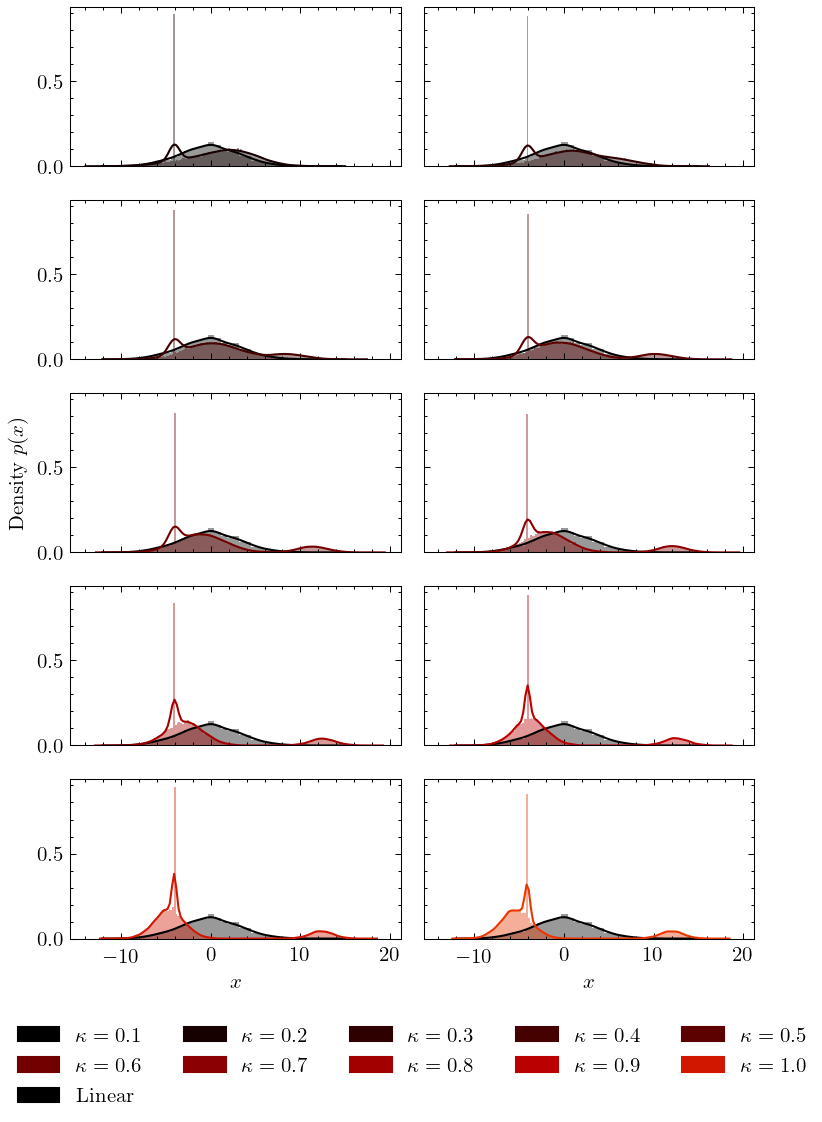

In [154]:
var = "X_6"
dfs = [(std[var], nonstd[var]) for (std, nonstd) in plot_data]

fig, axes = plt.subplots(5, 2, figsize=(6,8), sharex=True, sharey=True)
colors = [plt.get_cmap("gist_heat")(i/11/1.5) for i in range(len(plot_data)+1)]
axes = axes.flatten()
print(len(plot_data))
big = fig.add_subplot(111, frameon=False)
big.grid(False)

# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big.set_axis_off()
handles = []
labels = []
for i, (std, data) in enumerate(dfs):
    label = f"$\kappa = {(i+1)/10}$"
    ax = axes[i]
#     ax.hist(
#         std,
#         color=colors[0],
#         density=True,
#         bins=200,
#         alpha=1,
#     )
#     ax.hist(
#         data,
#         color=colors[i+1],
#         label=label,
#         density=True,
#         bins=200,
#         alpha=0.8,
#     )
    sns.distplot(std, color=colors[0], ax=ax, axlabel=False)
    sns.distplot(data, color=colors[i+1], ax=ax, axlabel=False, bins=150)
    
    leg_entry = mpatches.Patch(color=colors[i], label=label)
    handles.append(leg_entry)
    labels.append(label)
    
handles.append(mpatches.Patch(color=colors[0], label=f"Linear"))
labels.append("Linear")
sort = [0, 5, -1, 1, 6, 2, 7, 3, 8, 4, 9]
# fig.legend([handles[i] for i in sort], [labels[i] for i in sort], loc='lower center', bbox_to_anchor = (0.45, 0),
#           ncol=5, fancybox=True, shadow=True)

big.legend([handles[i] for i in sort], [labels[i] for i in sort], loc='lower center', bbox_to_anchor = (0.5, -.2),
          ncol=5, fancybox=True, shadow=True)
axes[4].set_ylabel("Density $p(x)$")
axes[-2].set_xlabel("$x$")
axes[-1].set_xlabel("$x$")
plt.tight_layout()
plt.savefig("./plots/nonlinear_transformation.pdf")

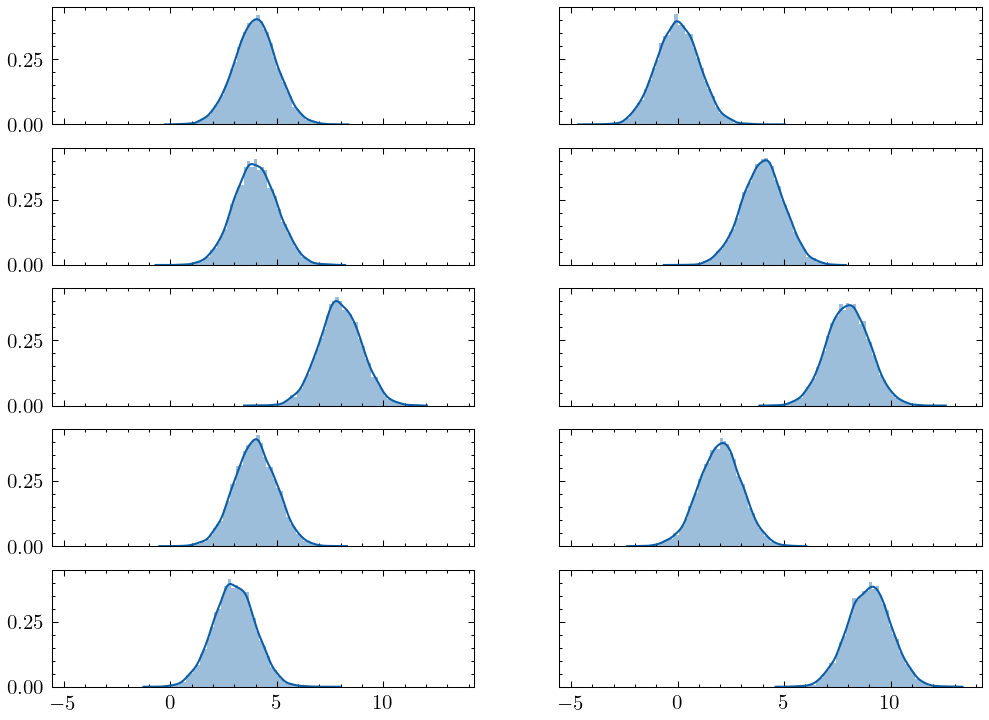

In [92]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi']= 150

fig, axes = plt.subplots(5,2, figsize=(8,6), sharex=True, sharey=True)
axes = axes.flatten()
big = fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big.axis("off")
for ax in axes:
    sns.distplot(np.random.normal(size=10000) + np.random.randint(0,10), axlabel=False, ax=ax),
        

plt.show()

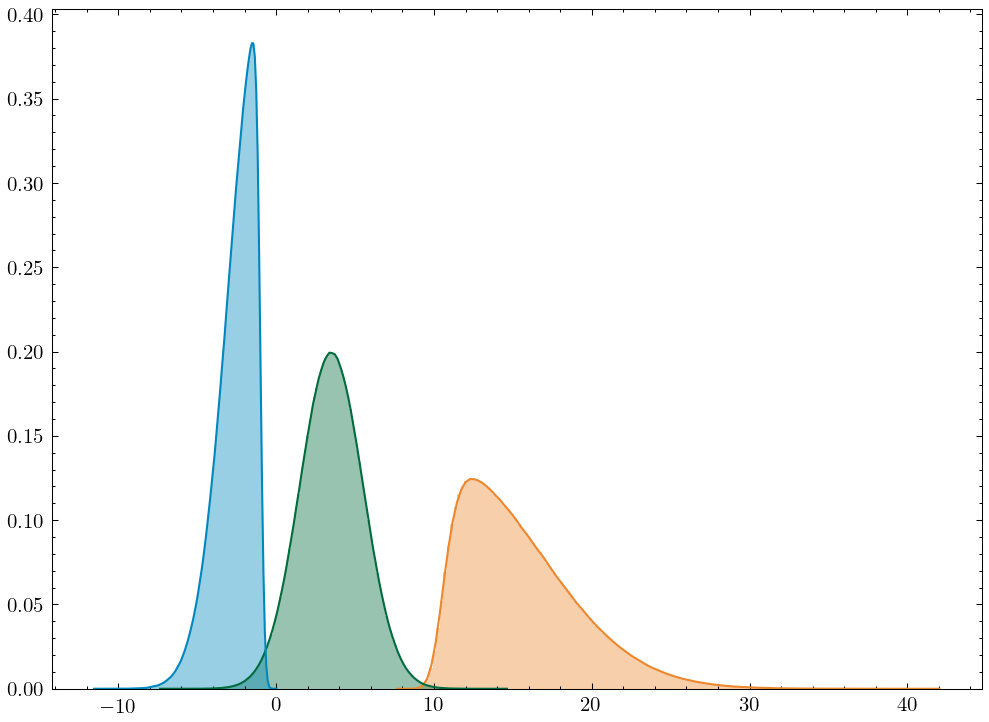

In [195]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
matplotlib.rcParams['figure.dpi']= 150

fig = plt.figure(figsize=(8,6))

N = int(1e7)

g0 = np.random.normal(size=N)
g1 = stats.skewnorm(a=2).rvs(size=N) +  stats.skewnorm(loc=10,a=40, scale=6).rvs(size=N)
g2 = np.random.normal(loc=3.5, scale=2, size=N)
g3 = stats.skewnorm(a=-10, scale=2, loc=-1).rvs(size=N)
g4 = stats.skewnorm(a=1, loc=2, scale=2).rvs(size=N) + stats.skewnorm(a=-10, loc=5, scale=3).rvs(size=N)

sns.distplot(g1, axlabel=False, color="#ED872D", bins=150),
sns.distplot(g2, axlabel=False, color="#006B3C", bins=150),
sns.distplot(g3, axlabel=False, color="#0087BD", bins=150),
        
ylim = plt.ylim()
plt.savefig("./plots/density_without_e.pdf")
plt.show()

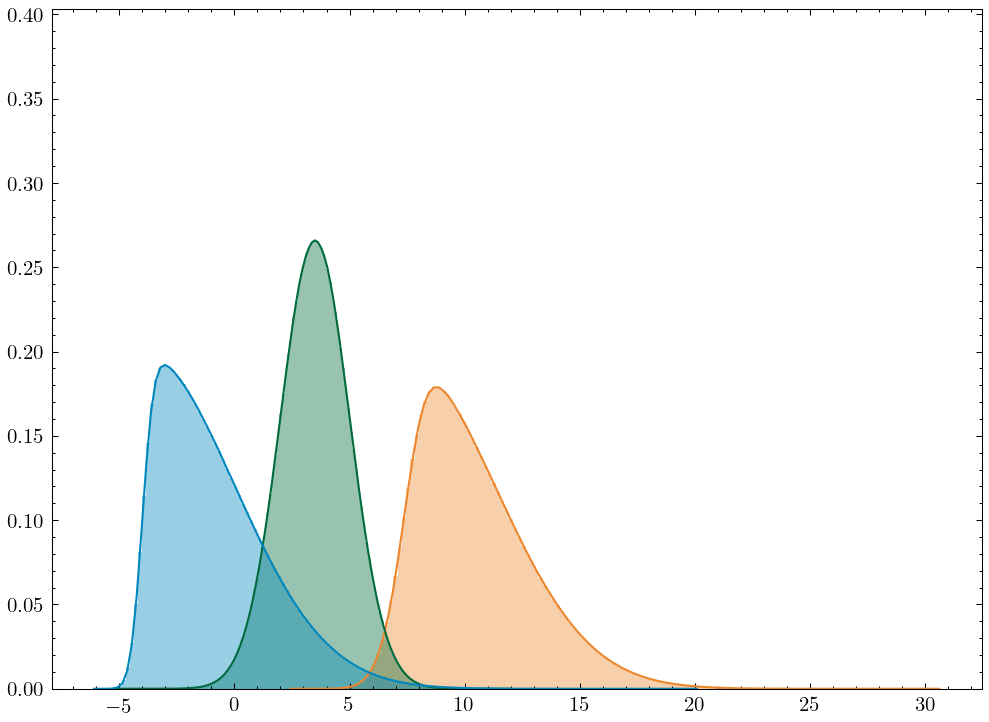

In [197]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
matplotlib.rcParams['figure.dpi']= 150

fig = plt.figure(figsize=(8,6))

N = int(1e7)

g0 = np.random.normal(size=N)
g1 = stats.skewnorm(a=-2).rvs(size=N) +  stats.skewnorm(loc=8,a=10, scale=4).rvs(size=N)
g2 = np.random.normal(loc=3.5, scale=1.5, size=N)
g3 = stats.skewnorm(a=10, scale=4, loc=-4).rvs(size=N)
g4 = stats.skewnorm(a=1, loc=2, scale=2).rvs(size=N) + stats.skewnorm(a=-10, loc=5, scale=3).rvs(size=N)

sns.distplot(g1, axlabel=False, color="#ED872D", bins=150),
sns.distplot(g2, axlabel=False, color="#006B3C", bins=150),
sns.distplot(g3, axlabel=False, color="#0087BD", bins=150),
        
plt.ylim(ylim)
plt.savefig("./plots/density_with_e.pdf")
plt.show()